In [6]:
import time
import torch
import matplotlib.pyplot as plt

from lichi_tw import LIChI
from torchvision.io import read_image, write_png

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sigma = 30
path_in = './test_images/SET12.png'

# Read image and Add noise

img = read_image(path_in)[None, :, :, :].float().to(device)
img_noisy = img + sigma * torch.randn_like(img)


In [7]:
from lichiin import LIChIin
from denoise_methods import LR, LLR

In [8]:
def lichi_in(img_noisy, sigma): ## only for initial pilot
    model = LIChIin()
    if sigma <= 10:
        img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method='n2n', p1=9, p2=6, k1=16, k2=64, w=65, s=3, M=6)
    elif sigma <= 30:
        img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method='n2n', p1=11, p2=6, k1=16, k2=64, w=65, s=3, M=9)
    else:
        img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method='n2n', p1=13, p2=6, k1=16, k2=64, w=65, s=3, M=11)
    img_lichi = img_lichi.clip(0, 255)
    return img_lichi

In [9]:
def lichi(img_noisy, sigma):
    model = LIChI()
    if sigma <= 10:
        img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method='n2n', p1=9, p2=6, k1=16, k2=64, w=65, s=3, M=6)
    elif sigma <= 30:
        img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method='n2n', p1=11, p2=6, k1=16, k2=64, w=65, s=3, M=9)
    else:
        img_lichi = model(img_noisy, sigma=sigma, constraints='affine', method='n2n', p1=13, p2=6, k1=16, k2=64, w=65, s=3, M=11)
    img_lichi = img_lichi.clip(0, 255)
    return img_lichi



In [10]:
img_lichi = lichi(img_noisy, sigma)
initpilot = lichi_in(img_noisy, sigma)

initalpilot_lr = LR(initpilot)
initalpilot_llr = LLR(initpilot, k=20)

lr = LR(img_noisy)
llr = LLR(img_noisy, k=20)

write_png(initpilot[0, :, :, :].byte().to("cpu"), "./initalpilot.png")
write_png(img_noisy[0, :, :, :].byte().to("cpu"), "./img_noisy.png")
write_png(initalpilot_lr.unsqueeze(0).byte().to("cpu"), "./initalpilot_lr.png")
write_png(initalpilot_llr.unsqueeze(0).byte().to("cpu"), "./initalpilot_llr.png")
write_png(initalpilot_lr.unsqueeze(0).byte().to("cpu"), "./lr.png")
write_png(initalpilot_llr.unsqueeze(0).byte().to("cpu"), "./llr.png")



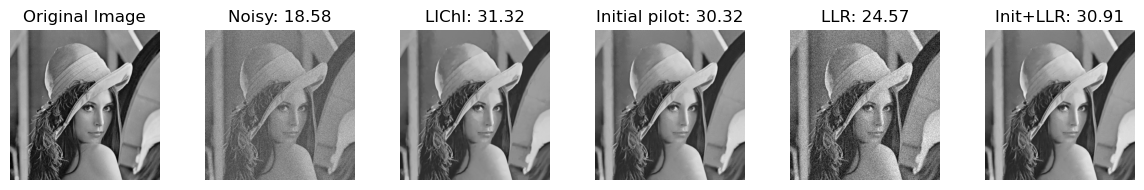

In [11]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms.functional import rgb_to_grayscale, resize

loaded_images = [img[0, 0, :, :],img_noisy[0, 0, :, :], img_lichi[0, 0, :, :],initpilot[0, 0, :, :],llr, initalpilot_llr]
# loaded_images = [img2[0, 0, :, :],img_noisy2[0, 0, :, :], img_lichi_med[0, 0, :, :],initpilot_med[0, 0, :, :],llr_med, initalpilot_llr_med]
titles = ["Original Image","Noisy","LIChI","Initial pilot","LLR","Init+LLR"]
fig, axes = plt.subplots(1, 6, figsize=(12, 2), gridspec_kw={'wspace': 0, 'hspace': 0})
for idx in range(6):
    
    psnr = 10*torch.log10(255**2 / torch.mean((img - loaded_images[idx])**2))
    loaded_np = loaded_images[idx]
    if idx!=0:
        axes[idx].set_title(f"{titles[idx]}: {psnr:.2f}", fontsize=12)
    else:
        axes[idx].set_title("Original Image")
    axes[idx].imshow(loaded_np, cmap='gray')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig("./tw_demo.png")
plt.show()

In [12]:
img_lichi = lichi(img_noisy, sigma)
write_png(img_lichi[0, :, :, :].byte().to("cpu"), "./img_lichi.png")

In [13]:
psnr_lichi = 10*torch.log10(255**2 / torch.mean((img - img_lichi)**2))
psnr_initpilot = 10*torch.log10(255**2 / torch.mean((img - initpilot)**2))
psnr_initalpilot_lr = 10*torch.log10(255**2 / torch.mean((img - initalpilot_lr)**2))
psnr_initalpilot_llr = 10*torch.log10(255**2 / torch.mean((img - initalpilot_llr)**2))

psnr_lr = 10*torch.log10(255**2 / torch.mean((img - lr)**2))
psnr_llr = 10*torch.log10(255**2 / torch.mean((img - llr)**2))

In [14]:
print(f"psnr_lichi: {psnr_lichi}")
print(f"psnr_initpilot: {psnr_initpilot}")
print(f"psnr_initalpilot_lr: {psnr_initalpilot_lr}")
print(f"psnr_initalpilot_llr: {psnr_initalpilot_llr}")

print(f"psnr_lr: {psnr_lr}")
print(f"psnr_llr: {psnr_llr}")

psnr_lichi: 31.32048797607422
psnr_initpilot: 30.31869888305664
psnr_initalpilot_lr: 24.544239044189453
psnr_initalpilot_llr: 30.907703399658203
psnr_lr: 19.495088577270508
psnr_llr: 24.566261291503906


In [72]:
## for benchmark
import os
from glob import glob
import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision.transforms.functional import rgb_to_grayscale
img_dir = '/Users/yangtaewon/Downloads/Urban100/image_SRF_2' # change path
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img_paths = glob(os.path.join(img_dir, '*.png'))
resize = transforms.Resize((256, 256))

images = []
for path in img_paths:
    img = read_image(path)
    img = rgb_to_grayscale(img)
    img = resize(img)                 
    images.append(img)

images = images[:50]
print(len(images))

50


In [93]:
from pytorch_msssim import ssim
sigma = 30
benchmark={
    "lichi_psnr":[],
    "initpilot_psnr":[],
    "initpilot_lr_psnr":[],
    "initpilot_llr_psnr":[],
    "lr_psnr":[],
    "llr_psnr":[],

    "lichi_ssim":[],
    "initpilot_ssim":[],
    "initpilot_lr_ssim":[],
    "initpilot_llr_ssim":[],
    "lr_ssim":[],
    "llr_ssim":[],
    
    "ori_img":[],
    "lichi_img":[],
    "initpilot_img":[],
    "initpilot_lr_img":[],
    "initpilot_llr_img":[],
    "lr_img":[],
    "llr_img":[],
}
for idx, img in enumerate(images):
    
    img = img[None, :, :, :].float().to(device)
    img_noisy = img + sigma * torch.randn_like(img)
    initpilot = lichi_in(img_noisy, sigma)
    initalpilot_lr = LR(initpilot)
    initalpilot_llr = LLR(initpilot, k=20)
    img_lichi = lichi(img_noisy, sigma)

    
    lr = LR(img_noisy)
    llr = LLR(img_noisy, k=20)

    psnr_lichi = 10*torch.log10(255**2 / torch.mean((img - img_lichi)**2))
    psnr_initpilot = 10*torch.log10(255**2 / torch.mean((img - initpilot)**2))
    psnr_initalpilot_lr = 10*torch.log10(255**2 / torch.mean((img - initalpilot_lr)**2))
    psnr_initalpilot_llr = 10*torch.log10(255**2 / torch.mean((img - initalpilot_llr)**2))
    
    psnr_lr = 10*torch.log10(255**2 / torch.mean((img - lr)**2))
    psnr_llr = 10*torch.log10(255**2 / torch.mean((img - llr)**2))

    ssim_lichi = ssim(img_lichi, img, size_average=True).item()
    ssim_initpilot = ssim(initpilot, img, size_average=True).item()
    ssim_initalpilot_lr = ssim(initalpilot_lr[None, None, :, :], img, size_average=True).item()
    ssim_initalpilot_llr = ssim(initalpilot_llr[None, None, :, :], img, size_average=True).item()
    ssim_lr = ssim(lr[None, None, :, :], img, size_average=True).item()
    ssim_llr = ssim(llr[None, None, :, :], img, size_average=True).item()

    print(f"{idx} psnr_lichi: {psnr_lichi}")
    print(f"psnr_initpilot: {psnr_initpilot}")
    print(f"psnr_initalpilot_lr: {psnr_initalpilot_lr}")
    print(f"psnr_initalpilot_llr: {psnr_initalpilot_llr}")
    print(f"psnr_lr: {psnr_lr}")
    print(f"psnr_llr: {psnr_llr}")

    print(f"{idx} ssim_lichi: {ssim_lichi}")
    print(f"ssim_initpilot: {ssim_initpilot}")
    print(f"ssim_initalpilot_lr: {ssim_initalpilot_lr}")
    print(f"ssim_initalpilot_llr: {ssim_initalpilot_llr}")
    print(f"ssim_lr: {ssim_lr}")
    print(f"ssim_llr: {ssim_llr}")
    
    benchmark["lichi_psnr"].append(psnr_lichi)
    benchmark["initpilot_psnr"].append(psnr_initpilot)
    benchmark["initpilot_lr_psnr"].append(psnr_initalpilot_lr)
    benchmark["initpilot_llr_psnr"].append(psnr_initalpilot_llr)
    benchmark["lr_psnr"].append(psnr_lr)
    benchmark["llr_psnr"].append(psnr_llr)

    benchmark["lichi_ssim"].append(ssim_lichi)
    benchmark["initpilot_ssim"].append(ssim_initpilot)
    benchmark["initpilot_lr_ssim"].append(ssim_initalpilot_lr)
    benchmark["initpilot_llr_ssim"].append(ssim_initalpilot_llr)
    benchmark["lr_ssim"].append(ssim_lr)
    benchmark["llr_ssim"].append(ssim_llr)
    
    benchmark["lichi_img"].append(img_lichi)
    benchmark["initpilot_img"].append(initpilot)
    benchmark["initpilot_lr_img"].append(initalpilot_lr)
    benchmark["initpilot_llr_img"].append(initalpilot_llr)
    benchmark["lr_img"].append(lr)
    benchmark["llr_img"].append(llr)
    benchmark["ori_img"].append(img)

0 psnr_lichi: 33.062416076660156
psnr_initpilot: 31.66996192932129
psnr_initalpilot_lr: 29.348756790161133
psnr_initalpilot_llr: 32.089900970458984
psnr_lr: 20.257049560546875
psnr_llr: 25.781761169433594
0 ssim_lichi: 0.8794452548027039
ssim_initpilot: 0.8169776201248169
ssim_initalpilot_lr: 0.7779079079627991
ssim_initalpilot_llr: 0.8598031997680664
ssim_lr: 0.22320957481861115
ssim_llr: 0.4625203013420105
1 psnr_lichi: 32.92477035522461
psnr_initpilot: 31.409286499023438
psnr_initalpilot_lr: 26.165922164916992
psnr_initalpilot_llr: 31.677413940429688
psnr_lr: 20.0384521484375
psnr_llr: 25.35173797607422
1 ssim_lichi: 0.8634648323059082
ssim_initpilot: 0.7970435619354248
ssim_initalpilot_lr: 0.6843074560165405
ssim_initalpilot_llr: 0.8388237357139587
ssim_lr: 0.23048116266727448
ssim_llr: 0.45801180601119995
2 psnr_lichi: 32.58905792236328
psnr_initpilot: 31.19083595275879
psnr_initalpilot_lr: 28.815715789794922
psnr_initalpilot_llr: 31.474594116210938
psnr_lr: 20.057479858398438
psn

In [94]:
import pickle
with open('benchmark.pkl', 'wb') as f:
    pickle.dump(benchmark, f)

In [109]:
with open('benchmark_URBAN100.pkl', 'rb') as f:
    benchmark = pickle.load(f)

In [110]:
import numpy as np

average_lichi_psnr = np.mean(benchmark["lichi_psnr"])
average_initpilot_psnr = np.mean(benchmark["initpilot_psnr"])
average_initpilot_lr_psnr = np.mean(benchmark["initpilot_lr_psnr"])
average_initpilot_llr_psnr = np.mean(benchmark["initpilot_llr_psnr"])
average_lr_psnr = np.mean(benchmark["lr_psnr"])
average_llr_psnr = np.mean(benchmark["llr_psnr"])

average_lichi_ssim = np.mean(benchmark["lichi_ssim"])
average_initpilot_ssim = np.mean(benchmark["initpilot_ssim"])
average_initpilot_lr_ssim = np.mean(benchmark["initpilot_lr_ssim"])
average_initpilot_llr_ssim = np.mean(benchmark["initpilot_llr_ssim"])
average_lr_ssim = np.mean(benchmark["lr_ssim"])
average_llr_ssim = np.mean(benchmark["llr_ssim"])

print("Average of benchmark['average_lichi']:", average_lichi_psnr)
print("Average of benchmark['average_initpilot_psnr']:", average_initpilot_psnr)
# print("Average of benchmark['average_initpilot_lr_psnr']:", average_initpilot_lr_psnr)
print("Average of benchmark['average_initpilot_llr_psnr']:", average_initpilot_llr_psnr)
# print("Average of benchmark['average_lr_psnr']:", average_lr_psnr)
print("Average of benchmark['average_llr_psnr']:", average_llr_psnr)

print("Average of benchmark['average_lichi_ssim']:", average_lichi_ssim)
print("Average of benchmark['average_initpilot_ssim']:", average_initpilot_ssim)
# print("Average of benchmark['average_initpilot_lr_ssim']:", average_initpilot_lr_ssim)
print("Average of benchmark['average_initpilot_llr_ssim']:", average_initpilot_llr_ssim)
# print("Average of benchmark['average_lr_ssim']:", average_lr_ssim)
print("Average of benchmark['average_llr_ssim']:", average_llr_ssim)

Average of benchmark['average_lichi']: 28.743624
Average of benchmark['average_initpilot_psnr']: 27.638784
Average of benchmark['average_initpilot_llr_psnr']: 27.513159
Average of benchmark['average_llr_psnr']: 24.276588
Average of benchmark['average_lichi_ssim']: 0.8702102836966514
Average of benchmark['average_initpilot_ssim']: 0.8266058191657066
Average of benchmark['average_initpilot_llr_ssim']: 0.8385827204585076
Average of benchmark['average_llr_ssim']: 0.6690133319795132
